In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

In [2]:
# Leitura dos dados
train_df = pd.read_csv('meds_train_alunos.csv')
test_df = pd.read_csv('meds_test_alunos.csv')

In [3]:
# Seleção das colunas de sinais (RSSI) e delays conforme especificação
features = ['rssi_1_1', 'rssi_1_2', 'rssi_1_3',
            'rssi_2_1', 'rssi_2_2', 'rssi_2_3',
            'rssi_3_1', 'rssi_3_2', 'rssi_3_3',
            'delay_1', 'delay_2', 'delay_3']

X = train_df[features]
y = train_df[['lat', 'lon','indoor']]

In [4]:
# Divisão dos dados
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

In [5]:
# Função para calcular a distância entre dois pontos geográficos
def haversine(lat1, lon1, lat2, lon2):
    """
    Calcula a distância em metros entre dois pontos definidos por latitude e longitude.
    """
    # Conversão de graus para radianos
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # Diferenças
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Fórmula de Haversine
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    c = 2 * np.arcsin(np.sqrt(a))
    # Raio da Terra (m)
    r = 6371000
    return c * r

In [6]:
# Aplicação do Random Florest
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
pred_rf = rf.predict(X_val)

In [7]:
# Calcular os erros (distância em metros)
errors_rf = []
for i in range(len(y_val)):
    actual_lat, actual_lon, actual_indoor = y_val.iloc[i]
    pred_lat, pred_lon, pred_indoor = pred_rf[i]
    
    # Calcula a distância usando haversine
    distance_error = haversine(actual_lat, actual_lon, pred_lat, pred_lon)
    
    # Penaliza o erro se a previsão de "indoor" for diferente do valor real
    indoor_error = 0 if actual_indoor == pred_indoor else 10  # Exemplo de penalização
    
    total_error = distance_error + indoor_error  # Somando o erro de distância com a penalização do indoor
    errors_rf.append(total_error)

In [8]:
# Métricas do Random Forest
print("Random Forest - Erro Médio:", np.mean(errors_rf))
print("Random Forest - Erro Mínimo:", np.min(errors_rf))
print("Random Forest - Erro Máximo:", np.max(errors_rf))
print("Random Forest - Desvio Padrão:", np.std(errors_rf))

Random Forest - Erro Médio: 5.862390985719765
Random Forest - Erro Mínimo: 1.4146461779773745e-09
Random Forest - Erro Máximo: 189.86184864040712
Random Forest - Desvio Padrão: 16.445633101881537


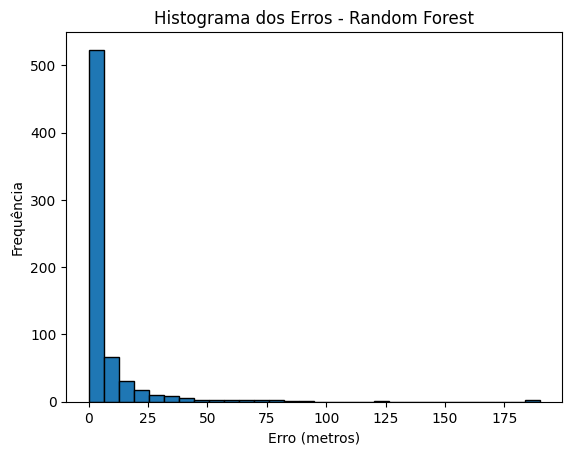

In [9]:
# Histograma dos erros
plt.figure()
plt.hist(errors_rf, bins=30, edgecolor='black')
plt.title("Histograma dos Erros - Random Forest")
plt.xlabel("Erro (metros)")
plt.ylabel("Frequência")
plt.show()

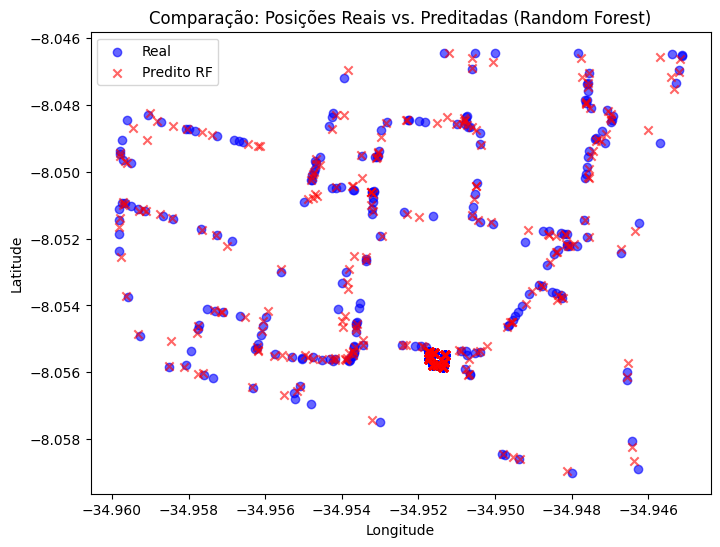

In [10]:
# Comparação: Posições Reais vs. Preditadas
plt.figure(figsize=(8, 6))
# Plotando as posições reais
plt.scatter(y_val['lon'], y_val['lat'], color='blue', label='Real', alpha=0.6)
# Plotando as posições preditas
plt.scatter(pred_rf[:,1], pred_rf[:,0], color='red', marker='x', label='Predito RF', alpha=0.6)
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Comparação: Posições Reais vs. Preditadas (Random Forest)")
plt.legend()
plt.show()

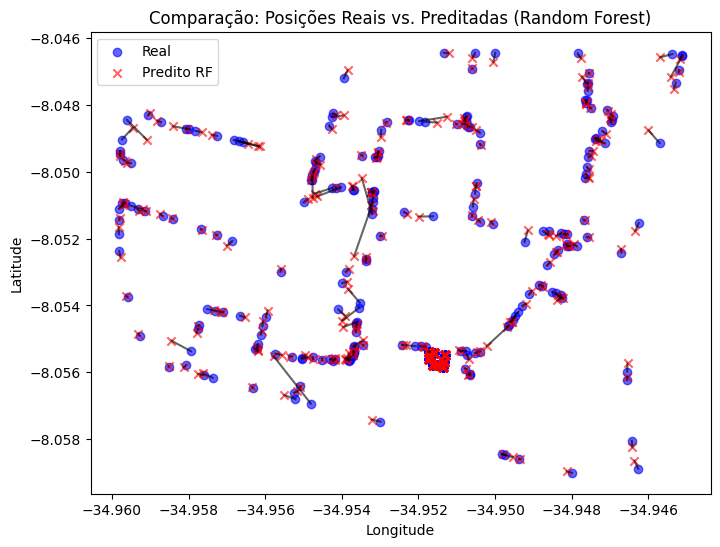

In [11]:
# Comparação: Posições Reais vs. Preditadas com Linhas Conectando
plt.figure(figsize=(8, 6))
# Plotando as posições reais
plt.scatter(y_val['lon'], y_val['lat'], color='blue', label='Real', alpha=0.6)
# Plotando as posições preditas
plt.scatter(pred_rf[:,1], pred_rf[:,0], color='red', marker='x', label='Predito RF', alpha=0.6)

# Adiciona linhas conectando os pontos reais e previstos, com cor mais escura
for i in range(len(y_val)):
    plt.plot([y_val['lon'].iloc[i], pred_rf[i, 1]], [y_val['lat'].iloc[i], pred_rf[i, 0]], color='black', alpha=0.6)

# Configurações do gráfico
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Comparação: Posições Reais vs. Preditadas (Random Forest)")
plt.legend()
plt.show()

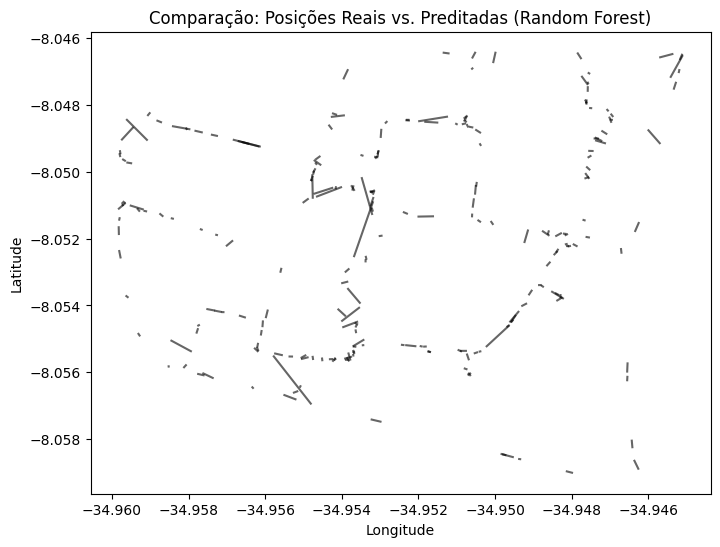

In [12]:
# Comparação: Apenas Linhas Conectando as Posições Reais e Preditadas
plt.figure(figsize=(8, 6))
# Adiciona apenas as linhas conectando os pontos reais e previstos
for i in range(len(y_val)):
    plt.plot([y_val['lon'].iloc[i], pred_rf[i, 1]], [y_val['lat'].iloc[i], pred_rf[i, 0]], color='black', alpha=0.6)

# Configurações do gráfico
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Comparação: Posições Reais vs. Preditadas (Random Forest)")
plt.show()

In [13]:
# Previsões para o conjunto de teste
X_test = test_df[features]
pred_test = rf.predict(X_test)

In [14]:
# Criação do DataFrame de submissão
submit_df = pd.DataFrame({
    'ponto_id': test_df['ponto_id'],
    'lat': pred_test[:, 0],
    'lon': pred_test[:, 1]
})

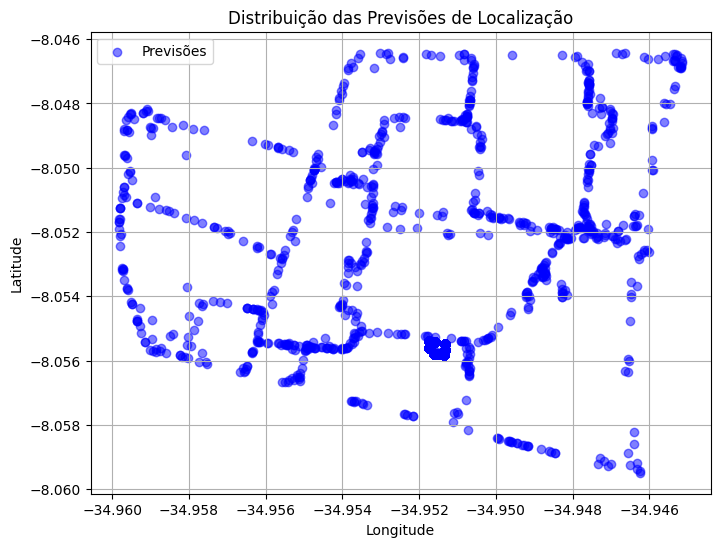

In [15]:
# Gráfico das Previsões de Localização
plt.figure(figsize=(8, 6))
plt.scatter(submit_df["lon"], submit_df["lat"], alpha=0.5, label="Previsões", color="blue")

# Personalizando o gráfico
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Distribuição das Previsões de Localização")
plt.legend()
plt.grid(True)

# Exibir o gráfico
plt.show()

In [17]:
# Salvando o arquivo de submissão
submit_df.to_csv("Resultados_EquipeX_MetodoRF.csv", index=False)
print("Arquivo de submissão gerado: Resultados_Random_Florest_com_indoor.csv")

Arquivo de submissão gerado: Resultados_Random_Florest_com_indoor.csv
